# APTOS Dataset Analysis

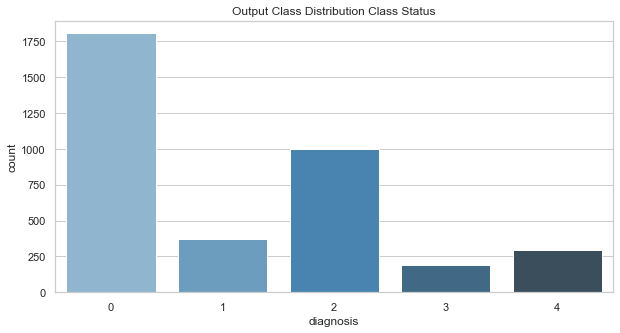

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 


train_labels = pd.read_csv(r'./aptos2019-blindness-detection/train.csv')
plot_classes(train_labels, "Class Status")


In [2]:
# As we have sever class imbalance we need to perform augmentation 
# augmentation using Image Augmenter

# First we will perform image preprocessing to get better from an image

train_labels.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


# Image Resizing to 256 x 256

In [10]:
import os
import cv2
import numpy as np

IMG_SIZE = 256


def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if (check_shape == 0):  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img


def circle_crop(img, sigmaX=30):
    """
    Create circular crop around image centre    
    """
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(
        img, (0, 0), sigmaX), -4, 128)
    return img

def image_resize_save(file):
    input_filepath = os.path.join('./','aptos2019-blindness-detection/' ,'train_images/', '{}.png'.format(file))
    output_filepath = os.path.join(
        './', 'aptos2019-blindness-detection/','train_images_resized/', '{}.png'.format(file))
    img = cv2.imread(input_filepath)
    img = circle_crop(img)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE, IMG_SIZE)))


print("Pre-Processing Started")

for i in train_labels['id_code']:
    image_resize_save(i)

print("Done")


Pre-Processing Started
Done


# Preparing Data set (train / test) 

In [15]:
'''
This function reads data from the train directory and updates as required
'''


def load_data():
    train_dir = os.path.join(
        './', 'aptos2019-blindness-detection/', 'train_images/')

    train = pd.read_csv(r'./aptos2019-blindness-detection/train.csv')

    train['file_path'] = train['id_code'].map(
        lambda x: os.path.join(train_dir, '{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train

train_labels_updated = load_data()
train_labels_updated.to_csv(r'./aptos2019-blindness-detection/train_updated.csv')
train_labels_updated.head()

,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./aptos2019-blindness-detection/train_images/0...,000c1434d8d7.png
1,001639a390f0,4,./aptos2019-blindness-detection/train_images/0...,001639a390f0.png
2,0024cdab0c1e,1,./aptos2019-blindness-detection/train_images/0...,0024cdab0c1e.png
3,002c21358ce6,0,./aptos2019-blindness-detection/train_images/0...,002c21358ce6.png
4,005b95c28852,0,./aptos2019-blindness-detection/train_images/0...,005b95c28852.png


# Train / Test Split Using 80% to train and 20% to test

In [17]:
from sklearn.model_selection import train_test_split

train, validate = train_test_split(train_labels_updated, test_size=0.2)
print(train.shape, validate.shape)

(2929, 4) (733, 4)


In [18]:
# Saving Train / Test csv updated
train.to_csv(r'./aptos2019-blindness-detection/train_split.csv')
validate.to_csv(r'./aptos2019-blindness-detection/validate_split.csv')

# Image Generator in form of ImageDataGenerator

In [30]:
from keras.preprocessing.image import ImageDataGenerator

def img_generator(train):
    HEIGHT = 320
    WIDTH = 320
    BATCH_SIZE = 8

    train_datagen = ImageDataGenerator(
        rescale=1./255, validation_split=0.2, horizontal_flip=True, featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=270,
        width_shift_range=0.2,
        height_shift_range=0.2,)

    train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=r"./aptos2019-blindness-detection/train_images_resized/",
                                                        x_col="file_name",
                                                        y_col="diagnosis",
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical",
                                                        target_size=(
                                                            HEIGHT, WIDTH),
                                                        subset='training')

    valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=r"./aptos2019-blindness-detection/train_images_resized/",
                                                        x_col="file_name",
                                                        y_col="diagnosis",
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical",
                                                        target_size=(
                                                            HEIGHT, WIDTH),
                                                        subset='validation')


    return train_generator, valid_generator


train_data, validate_data = img_generator(train)
print(train_data)


Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.


# Creating Model

In [32]:
# Hyper parameters

BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5


In [33]:
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(
        weights='imagenet', include_top=False, input_tensor=input_tensor)
    # base_model = ResNet50(
    #     weights=None, include_top=False, input_tensor=input_tensor)
    # base_model.load_weights(
    #     'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model


model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)


In [34]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [38]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(WARMUP_LEARNING_RATE),
              loss='categorical_crossentropy', metrics=['accuracy'])
history_warmup = model.fit(train_data, validation_data=validate_data, epochs=WARMUP_EPOCHS, verbose=1)

C:\Users\abdul\anaconda3\envs\isee\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\abdul\anaconda3\envs\isee\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/2
293/293 [==============================] - 1396s 5s/step - loss: 2.0248 - accuracy: 0.4104 - val_loss: 1.3736 - val_accuracy: 0.4274
Epoch 2/2
293/293 [==============================] - 1271s 4s/step - loss: 1.3638 - accuracy: 0.4603 - val_loss: 1.2698 - val_accuracy: 0.4735
